### Set up google colab

In [2]:
# Set up google drive in google colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import Libraries

In [3]:
import random
import glob, os
import math
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image,ImageFilter, ImageEnhance
import cv2
import torch.optim as optim
from torchvision.ops import nms
from tqdm import tqdm
import time

import pandas as pd
import random

### Define Model Hyper Parameters

In [4]:
input_image_height = 500
input_image_width = 500

### Handle Training Data

##### Data augmentation

In [5]:
# Random blur on training image
def random_blur(img):
  if random.random() < 0.5:
    return img
  
  rad = random.choice([1,2])
  img = img.filter(ImageFilter.BoxBlur(radius=rad))
  return img


# Random brightness, contrast, satutration and hue
def random_color(img):
  if random.random() < 0.1:
    return img

  img = transforms.ColorJitter(brightness=(0.5,2.0), contrast=(0.5,2.0), saturation=(0.5,2.0), hue=(-0.25,0.25))(img)
  return img

# Random horizontal flip
def random_flip(img, gt_box):
  if random.random() < 0.5:
    return img,gt_box

  img = transforms.RandomHorizontalFlip(p=1)(img)
  temp = (gt_box[:,1]).copy()
  gt_box[:,1] = img.size[0] - gt_box[:,0] #x1
  gt_box[:,0] = img.size[0] - temp #x2

  return img, gt_box


# Random crop on image
def random_crop(img, gt_box, labels):
  if random.random() < 0.5:
    return img,gt_box,labels
  width, height = img.size
  select_w = random.uniform(0.6*width, width)
  select_h = random.uniform(0.6*height, height)

  start_x = random.uniform(0,width - select_w)
  start_y = random.uniform(0,height - select_h)

  left = start_x
  upper = start_y
  right = start_x + select_w
  bottom = start_y + select_h

  gt_box_copy = gt_box.copy()

  gt_box_copy[gt_box_copy[:,0] < left, 0] = left
  gt_box_copy[gt_box_copy[:,1] > right, 1] = right
  gt_box_copy[gt_box_copy[:,2] < upper, 2] = upper
  gt_box_copy[gt_box_copy[:,3] > bottom, 3] = bottom

  final_gt_box = []
  final_labels = []

  for i in range((gt_box_copy.shape[0])):
    if (((gt_box_copy[i,1] - gt_box_copy[i,0])/(gt_box[i,1]-gt_box[i,0])) < 0.5):
      continue
    if (((gt_box_copy[i,3] - gt_box_copy[i,2])/(gt_box[i,3] - gt_box[i,2])) < 0.5):
      continue
    final_gt_box.append(gt_box_copy[i])
    final_labels.append(labels[i])

  if len(final_gt_box) == 0:
    return img,gt_box,labels

  final_gt_box = np.array(final_gt_box)
  final_gt_box[:,0] = final_gt_box[:,0] - left
  final_gt_box[:,1] = final_gt_box[:,1] - left
  final_gt_box[:,2] = final_gt_box[:,2] - upper
  final_gt_box[:,3] = final_gt_box[:,3] - upper

  return img.crop((left, upper, right, bottom)), final_gt_box, final_labels

##### Create Pytorch Dataset and Dataloader

In [6]:
class apple_data(Dataset):
    def __init__(self, img_dir,desc_dir,type_list, isTrain, transform = None):
        super().__init__()
        self.img_dir = img_dir
        self.desc_dir = desc_dir
        self.type_list = type_list
        self.isTrain = isTrain
        self.transform = transform


        self.img_names = []
        self.img_descs = []
        for img in sorted(os.listdir(img_dir)):
          if img[:-4] in self.type_list:
            self.img_names.append(img)
        
        for desc in sorted(os.listdir(desc_dir)):
          if desc[:-4] in  self.type_list:
            self.img_descs.append(desc)
       
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names]
        self.img_descs = [os.path.join(desc_dir, img_desc) for img_desc in self.img_descs]             
        
        self.loc_gts = []
        self.loc_labels = []
        self.final_img_names = []
        
        for i, file in enumerate(self.img_descs):

          gt = []
          loc_lab = []

          data = pd.read_csv(file)

          for j in range(len(data)):
            c_x = data["c-x"]
            c_x = c_x[j]
            c_y = data["c-y"]
            c_y = c_y[j]
            radius = data["radius"]
            radius = radius[j]
            loc1 = c_x - radius
            loc2 = c_x + radius
            loc3 = c_y - radius
            loc4 = c_y + radius
            lab = 1

            # if ht or width is less than 10, ignore the gt box
            if ((loc2 - loc1) < 10 ) or ((loc4 - loc3) < 10):
               continue

            gt.append([int(loc1),int(loc2),int(loc3),int(loc4)])
            loc_lab.append(lab)
          
          if (len(gt) == 0):
            continue
          
          self.loc_gts.append(gt)
          self.loc_labels.append(loc_lab)
          self.final_img_names.append(self.img_names[i])

        self.img_names = self.final_img_names
             
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(img_name)

        arr_loc_gts = np.array(self.loc_gts[idx])
        label = self.loc_labels[idx]

        if self.isTrain:
          img = random_blur(img)
          img = random_color(img)
          img,arr_loc_gts = random_flip(img,arr_loc_gts)
          img,arr_loc_gts,label = random_crop(img,arr_loc_gts,label)
        
        img_h_pre = img.size[1]
        img_w_pre = img.size[0]
        
        if self.transform:
            img = self.transform(img)
            
        img_h_post = img.shape[1]
        img_w_post = img.shape[2]
        
        height_ratio = img_h_post/img_h_pre
        width_ratio = img_w_post/img_w_pre
    
        arr_loc_gts[:,0] = arr_loc_gts[:,0]*width_ratio
        arr_loc_gts[:,1] = arr_loc_gts[:,1]*width_ratio
        arr_loc_gts[:,2] = arr_loc_gts[:,2]*height_ratio
        arr_loc_gts[:,3] = arr_loc_gts[:,3]*height_ratio
                        
        gts = (arr_loc_gts).tolist()
        
        
        return img, gts, label

In [7]:
'''
While using pretrained models - 
Pytorch torchvision documentation - https://pytorch.org/docs/master/torchvision/models.html
The images have to be loaded in to a range of [0, 1] and then 
normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
'''

transform = transforms.Compose(
    [transforms.Resize((input_image_height,input_image_width)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

##### Split into train and validations 

In [8]:
# Location of my dataset on My Google Drive
image_path = "drive/My Drive/Deep Learning/CS4240-Project/data/apples/images"
annotation_path = "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations"

In [9]:
# Shuffle data
list_images = os.listdir(image_path)
list_annotations = os.listdir(annotation_path)

mapIndexPosition = list(zip(list_images, list_annotations))
random.shuffle(mapIndexPosition)
list_images, list_annotations = zip(*mapIndexPosition)

train_images = []
valid_images = []
test_images = []

for i, file in enumerate(list_images):
  if i < 896: 
    train_images.append(file[:-4])
  elif i > 1007:
    test_images.append(file[:-4])
  else: 
    valid_images.append(file[:-4])

print(len(train_images))
print(train_images)
print(len(valid_images))
print(len(test_images))

small_train_images = train_images[:30]
print(len(small_train_images))

small_valid_images = valid_images[:20]
print(len(small_valid_images))

896
['20130320T005944.964239.Cam6_42', '20130320T013041.764265_31', '20130320T013120.050671_42', '20130320T005027.238508.Cam6_53', '20130320T005741.342707.Cam6_21', '20130320T004914.094128.Cam6_51', '20130320T005426.100545.Cam6_42', '20130320T005908.963493.Cam6_31', '20130320T005545.911690.Cam6_41', '20130320T013508.817326_12', '20130320T013514.722190_21', '20130320T004720.568015.Cam6_63', '20130320T004359.801846.Cam6_21', '20130320T013608.056531_21', '20130320T013242.719107_13', '20130320T013321.386510_31', '20130320T005558.673956.Cam6_23', '20130320T005423.052856.Cam6_23', '20130320T005823.629322.Cam6_43', '20130320T013353.387174_33', '20130320T005445.339056.Cam6_32', '20130320T005807.247987.Cam6_24', '20130320T005131.239822.Cam6_11', '20130320T004910.284546.Cam6_21', '20130320T013331.481970_22', '20130320T005136.192297.Cam6_33', '20130320T005056.572492.Cam6_32', '20130320T013511.293499_22', '20130320T013631.104621_63', '20130320T005411.624125.Cam6_51', '20130320T013152.622837_22', '

In [10]:
train_dataset = apple_data("drive/My Drive/Deep Learning/CS4240-Project/data/apples/images/", "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations/", train_images, True, transform)
valid_dataset = apple_data("drive/My Drive/Deep Learning/CS4240-Project/data/apples/images/", "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations/", valid_images, False, transform)
test_dataset = apple_data("drive/My Drive/Deep Learning/CS4240-Project/data/apples/images/", "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations/", test_images, False, transform)
small_train_dataset = apple_data("drive/My Drive/Deep Learning/CS4240-Project/data/apples/images/", "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations/", small_train_images, True, transform)
small_valid_dataset = apple_data("drive/My Drive/Deep Learning/CS4240-Project/data/apples/images/", "drive/My Drive/Deep Learning/CS4240-Project/data/apples/annotations/", small_valid_images, False, transform)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))
print(len(small_train_dataset))
print(len(small_valid_dataset))

846
102
108
30
18


##### Validation class images

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1)
valid_loader = DataLoader(valid_dataset, batch_size=1)
test_loader = DataLoader(valid_dataset, batch_size=1)
small_train_loader = DataLoader(small_train_dataset, batch_size=1)
small_valid_loader = DataLoader(small_valid_dataset, batch_size=1)

#### Export Data Loaders

In [ ]:
torch.save(train_loader, "drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/train_loader.pt")
torch.save(valid_loader, "drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/valid_loader.pt")
torch.save(test_loader, "drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/test_loader.pt")
torch.save(small_train_loader, "drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/small_train_loader.pt")
torch.save(small_valid_loader, "drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/small_valid_loader.pt")


### Visualise input image with box co-ordinates provided in format - x0,x1,y0,y1

In [ ]:
# Given input image, draw rectangles as specified by gt_box and display
def visualize_tensor(img, gt_box, save_image='',tb_writer=None):
    plt.figure(figsize=(5,5))
    transform_img = inv_normalize(img[0]).permute(1,2,0).to('cpu').numpy()
    transform_img = transform_img.copy()
    for box in gt_box:
        x0, x1, y0, y1 = box
        cv2.rectangle(transform_img, (int(x0),int(y0)), (int(x1),int(y1)), color=(0, 255, 255), thickness=2)
    
    if tb_writer:
      # grid = torchvision.utils.make_grid(transform_img)
      tb_writer.add_image(save_image, transform_img, dataformats='HWC')
    elif save_image == '':
        plt.imshow(transform_img)
        plt.show()  
    else:
        plt.imshow(transform_img)
        plt.savefig(save_image + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


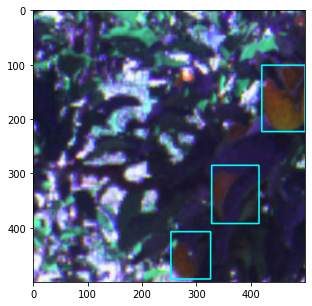

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


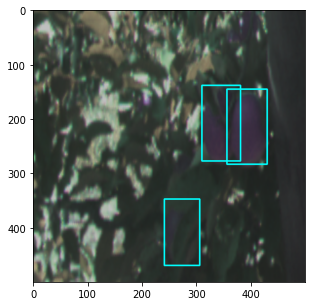

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


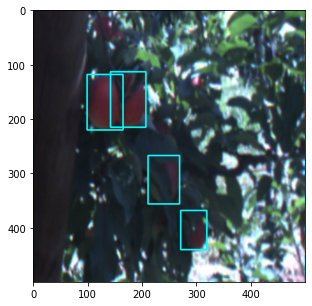

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


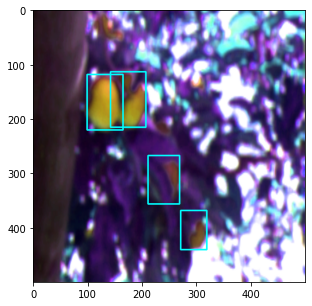

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


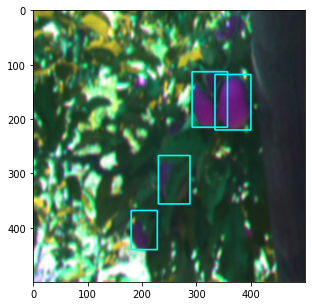

In [ ]:
for i in range(0,5):
  img, gt_box, label = next(iter(train_loader))
  visualize_tensor(img, gt_box)